C:\Users\Thomas\Documents\Data_Science\.venv\Lib\site-packages\sklearn\base.py:442: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 1.6.1 when using version 1.7.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Modèle chargé avec succès depuis MLflow.
Calcul des objets SHAP Explanation...
Objets SHAP Explanation calculés.
Génération du graphique d'importance globale.


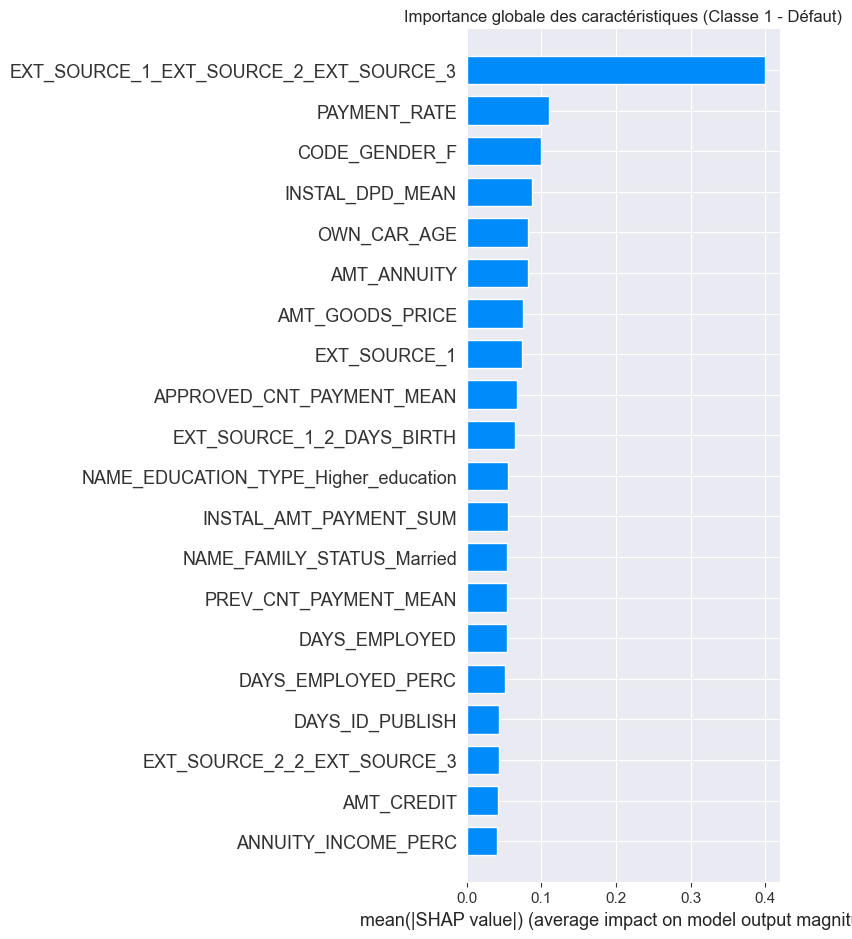

Génération du graphique d'explication locale pour un client.


Graphique d'explication locale sauvegardé dans 'shap_local_explanation.html'
Second graphique d'explication locale sauvegardé dans 'shap_local_explanation_2.html'


In [2]:
import shap
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import mlflow
import mlflow.lightgbm # Importation nécessaire pour charger le modèle LightGBM

# -------------------------------------------------------------
# 1. Fonction d'analyse SHAP (Version finale et corrigée)
# -------------------------------------------------------------

def run_shap_analysis(run_id, model_name="lightgbm_model", n_clients=5000):
    """
    Charge un modèle LightGBM depuis MLflow et effectue une analyse SHAP.
    """
    try:
        # 1. Charger le modèle
        model_uri = f"runs:/{run_id}/{model_name}"
        model = mlflow.lightgbm.load_model(model_uri)
        print("Modèle chargé avec succès depuis MLflow.")

        # 2. Charger les données
        df = pd.read_parquet('../data/final_dataset.parquet')
        X = df[df['TARGET'].notnull()].drop(columns=['TARGET', 'SK_ID_CURR'])
        X_sample = X.sample(n=n_clients, random_state=42)

        # 3. Créer l'explainer et calculer l'objet Explanation
        print("Calcul des objets SHAP Explanation...")
        explainer = shap.TreeExplainer(model)
        # La nouvelle API retourne un objet Explanation, qui contient tout
        explanation_object = explainer(X_sample)
        print("Objets SHAP Explanation calculés.")

        # 4. Analyse globale (importance des caractéristiques)
        print("Génération du graphique d'importance globale.")

        # La fonction summary_plot accepte l'objet Explanation directement
        shap.summary_plot(explanation_object, plot_type="bar", show=False)

        plt.title("Importance globale des caractéristiques (Classe 1 - Défaut)")
        plt.tight_layout()
        plt.savefig("shap_global_importance.png")
        plt.show()

        # 5. Analyse locale (pour un client spécifique)
        print("Génération du graphique d'explication locale pour un client.")
        client_index_to_explain = 0
        shap.initjs()

        # La fonction force_plot accepte aussi l'objet Explanation
        force_plot_html = shap.force_plot(
            explanation_object[client_index_to_explain],
            show=False,
            matplotlib=False
        )
        shap.save_html("shap_local_explanation.html", force_plot_html)
        print("Graphique d'explication locale sauvegardé dans 'shap_local_explanation.html'")

        # Exemple d'analyse locale pour un autre client
        client_index_to_explain_2 = 1
        force_plot_html_2 = shap.force_plot(
            explanation_object[client_index_to_explain_2],
            show=False,
            matplotlib=False
        )
        shap.save_html("shap_local_explanation_2.html", force_plot_html_2)
        print("Second graphique d'explication locale sauvegardé dans 'shap_local_explanation_2.html'")


    except Exception as e:
        print(f"Une erreur est survenue : {e}")
        import traceback
        traceback.print_exc()

# -------------------------------------------------------------
# 2. Exécution du script
# -------------------------------------------------------------

if __name__ == "__main__":
    # Remplacez l'ID et le nom du modèle pour qu'ils correspondent à votre meilleur modèle
    run_id_du_modele_lgbm_v1 = "24ec2fae9561442caa2c7d4f11b67f15"
    run_shap_analysis(run_id=run_id_du_modele_lgbm_v1, model_name="lightgbm_model")

L'analyse SHAP a permis de mettre en lumière les facteurs qui influencent les prédictions de notre modèle LightGBM. L'importance globale des caractéristiques montre clairement que les scores externes (EXT_SOURCE_2 et EXT_SOURCE_3) sont les variables les plus déterminantes pour les décisions du modèle. L'analyse locale, illustrée par les force_plot de SHAP, a confirmé cette observation. Elle a démontré comment, pour un client refusé, des valeurs faibles de ces scores externes poussent sa probabilité de faillite à la hausse. À l'inverse, pour un client accepté, des valeurs plus élevées de ces mêmes scores ont été le facteur principal pour un score négatif. Cette analyse nous permet de justifier clairement les décisions du modèle en se basant sur des variables concrètes, ce qui est une exigence clé de la mission.